In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score

In [2]:
valid_df = pd.read_csv('/home/pervinco/upstage-cv-classification-cv7/dataset/valid_dataset.csv')
submission_df = pd.read_csv('/home/pervinco/upstage-cv-classification-cv7/runs/best_9559_single_efficientnet_528/preds/submission.csv')

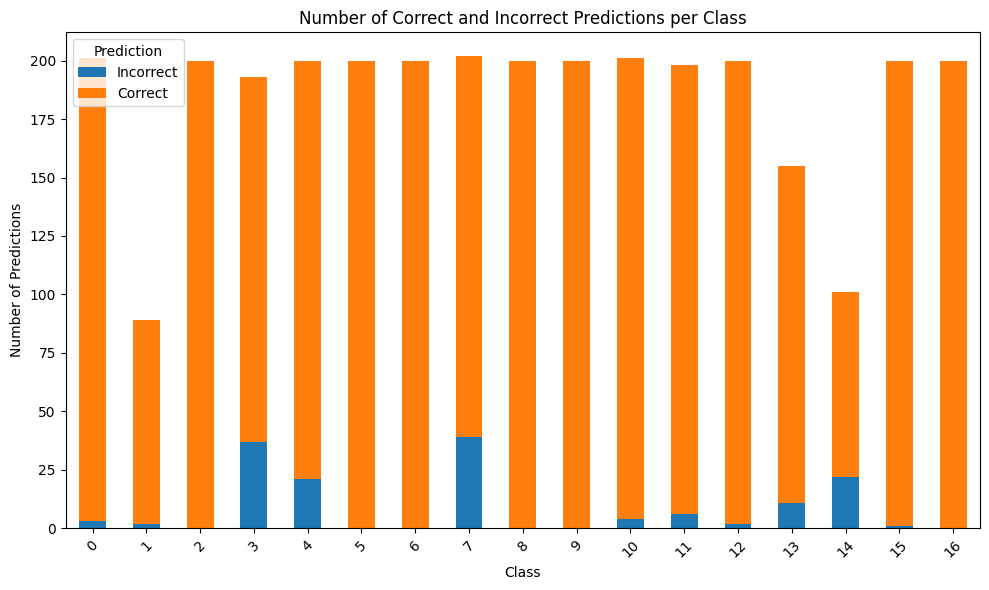

In [3]:
# 각 클래스별로 맞춘 개수와 틀린 개수 계산
valid_df['correct'] = valid_df['target'] == submission_df['target']

# 클래스별 맞춘 개수와 틀린 개수 집계
results = valid_df.groupby('target')['correct'].value_counts().unstack().fillna(0)
results.columns = ['Incorrect', 'Correct']

# 클래스별 맞춘 개수와 틀린 개수 시각화
results.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Correct and Incorrect Predictions per Class')
plt.xlabel('Class')
plt.ylabel('Number of Predictions')
plt.legend(title='Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
valid_df['correct'] = valid_df['target'] == submission_df['target']

results = valid_df.groupby('target').agg(
    correct_count=('correct', 'sum'),
    incorrect_count=('correct', lambda x: len(x) - x.sum()),
    total_count=('correct', 'count')
)

results['accuracy'] = results['correct_count'] / results['total_count']

overall_accuracy = accuracy_score(valid_df['target'], submission_df['target'])

f1_macro = f1_score(valid_df['target'], submission_df['target'], average='macro')

print("각 클래스별 맞춘 개수, 틀린 개수 및 정확도:")
print(results)

print(f"\n전체 정확도: {overall_accuracy:.4f}")
print(f"F1 매크로 점수: {f1_macro:.4f}")

각 클래스별 맞춘 개수, 틀린 개수 및 정확도:
        correct_count  incorrect_count  total_count  accuracy
target                                                       
0                 198                3          201  0.985075
1                  87                2           89  0.977528
2                 200                0          200  1.000000
3                 156               37          193  0.808290
4                 179               21          200  0.895000
5                 200                0          200  1.000000
6                 200                0          200  1.000000
7                 163               39          202  0.806931
8                 200                0          200  1.000000
9                 200                0          200  1.000000
10                197                4          201  0.980100
11                192                6          198  0.969697
12                198                2          200  0.990000
13                144               11     

In [7]:
# 정답과 예측 비교하여 오답률 계산
valid_df['correct'] = valid_df['target'] == submission_df['target']
class_counts = valid_df['target'].value_counts()
incorrect_counts = valid_df[~valid_df['correct']]['target'].value_counts()

# 오답률 계산
incorrect_rates = incorrect_counts / class_counts
incorrect_rates = incorrect_rates.fillna(0.0)  # 없는 클래스는 0으로 설정

# 가중치 정규화 (오답률 자체를 가중치로 사용)
weights = incorrect_rates / incorrect_rates.sum()

# 없는 클래스의 가중치를 기본값으로 설정
weights = weights.replace(0.0, weights.max())

# 가중치를 tensor로 변환
weights_tensor = torch.tensor(weights.sort_index().values, dtype=torch.float32)

print("클래스별 가중치:")
print(weights_tensor)

클래스별 가중치:
tensor([0.0169, 0.0255, 0.2472, 0.2176, 0.1192, 0.2472, 0.2472, 0.2191, 0.2472,
        0.2472, 0.0226, 0.0344, 0.0113, 0.0805, 0.2472, 0.0057, 0.2472])
